<a href="https://colab.research.google.com/github/satuelisa/NLPF/blob/main/NLPF_06_P.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

As warm-up, let's take a look at the dynamic-programming algorithm to compute the *edit distance* ([Levenshtein distance](https://en.wikipedia.org/wiki/Levenshtein_distance)) of two strings. Let's assume that the cost of inserting a character is a constant, the cost of inserting a character is another constant, and that the replacement cost depends on the pair being replaced, with a default value for when none is given.

In [1]:
def editdist(p, q, elimination = 1, insertion = 1, defrep = 1, repcost = dict()):
    d = dict()
    np = len(p) + 1 # length of first string plus one 
    nq = len(q) + 1 # length of second string plus one
    for i in range(np): # initialize each row
        d[(i, 0)] = i * insertion
    for j in range(nq): # initialize each column
        d[(0, j)] = j * elimination
    for i in range(1, np):
        for j in range(1, nq):
            lp = p[i - 1] # corresponding letter of the first string
            lq = q[j - 1] # corresponding letter of the second string
            eli = d[(i - 1, j)] + elimination
            ins = d[(i, j - 1)] + insertion
            ree = d[(i - 1, j - 1)] # no cost of replacement unless they differ
            if lp != lq:
              # include cost of that pair or default cost if undefined
              ree += repcost.get((lp, lq), defrep) 
            d[(i, j)] = min(eli, ins, ree) # dynamic programming step: the cheapest option wins
    return d[(np -1, nq - 1)] # final cost
 
print(editdist("orthography", "ortografy"))

3


We can specify special pairs for when replacement is easier than usual.

In [2]:
print(editdist("elisa", "élise", repcost = {('e', 'é'): 0.1, ('é', 'e'): 0.2}))

1.1


Now we have a different sense of "word similarity" that will be explored in the first question of this week's reflection quiz in the content of spell-checking. For the second question, we will start off with *n*-grams and `WordNet` to figure out what are possible ways a given sentence could continue. Let's use Twitter data (which is also one of the case studies in the R textbook).

In [3]:
import nltk
nltk.download('twitter_samples') # once per computer

[nltk_data] Downloading package twitter_samples to /root/nltk_data...
[nltk_data]   Package twitter_samples is already up-to-date!


True

What's in it?

In [4]:
from nltk.corpus import twitter_samples
print(twitter_samples.fileids())

['negative_tweets.json', 'positive_tweets.json', 'tweets.20150430-223406.json']


We do not need labels for this, just the text of the tweets themselves.

In [5]:
corpus = twitter_samples.strings()
print(len(corpus))

30000


In [6]:
print(corpus[42])

Ouucchhh one of my wisdom teeth are coming through :(


In this example, I will use bigrams only, meaning *n* = 2 (the second quiz question lets you play with this more).

In [7]:
from nltk.tokenize import RegexpTokenizer
tokenizer = RegexpTokenizer(r'\w+') # remove punctuation

from collections import defaultdict
freq = defaultdict(int) # count bigraph occurences 

for tweet in corpus:
  tokens = tokenizer.tokenize(tweet) 
  # not skipping stop words on purpose today
  for bigram in nltk.ngrams(tokens, 2):
      freq[bigram] += 1

Let's see how many combinations we got and how the frequencies are distributed (we should expect it to be heavy-tailed so we need a log scale on the vertical axis).

In [8]:
print(len(freq))
from collections import Counter
counts = Counter(freq.values())

146912


This can now be a barchart that effectively is a histogram.

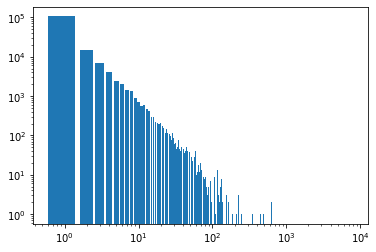

In [9]:
import matplotlib.pyplot as plt
plt.bar(counts.keys(), counts.values())
plt.xscale('log')
plt.yscale('log')

Yep, Zipf's Law is visible here as well. Now, not just *any* two words that happened to be following one another are necessarily a **meaningful** combination of words. We can use *pointwise mutual information* (PMI) as a way to quantify wheyjet two words are together by chance or on purpose (the latter implying that they depend on each other in some sense). This can be automated with `ntlk`.

In [10]:
# join the tweets into a single big string
howmany = 10000 # faster with less text
text = '\n'.join(corpus[:howmany])
length = 1000
start = len(text) // 2 # midpoint
end = start + length
spacer = '*' * 20
print(spacer, '\nRaw\n', text[start:end])

# let's clean out all URLs (tweets contain a surprising amount of them) with a regular expression
# see https://stackoverflow.com/questions/11331982/how-to-remove-any-url-within-a-string-in-python
import re
text = re.sub('http[s]?://\S+', '', text)
print(spacer, '\nNo URLs\n', text[start:end])

# all HTMl tags need to go, too
tags = re.compile(r'<[^>]+>') # like <em>
symbols = re.compile(r'&[^;]+;') # like &amp;
text = tags.sub('', text)
text = symbols.sub(' ', text)
print(spacer, '\nNo HTML\n', text[start:end])

# also twitter username tags @something are best thrown out for our purposesr
text = re.sub('@[A-Za-z0-9_]+', '', text)
print(spacer, '\nNo usernames\n', text[start:end])

# and yes, hashtags as well
text = re.sub('#[A-Za-z0-9]+', '', text)
print(spacer, '\nNo hashtags\n', text[start:end])

# and all words containing numbers, we should not try to autocomplete numbers
text = re.sub(r'[0-9]+', '', text)
print(spacer, '\nNo digits\n', text[start:end])

# no emojis, too
# see https://thewebdev.info/2022/04/16/how-to-remove-emojis-from-a-string-in-python/

emote = re.compile(pattern = "[" u"\U0001F600-\U0001F64F" u"\U0001F300-\U0001F5FF" u"\U0001F680-\U0001F6FF" u"\U0001F1E0-\U0001F1FF" "]+", flags = re.UNICODE)
text = emote.sub(r'', text)
print(spacer, '\nNo emojis\n', text[start:end])

******************** 
Raw
 the #Cheltenham area :)
Hi beautiful follow me please? :) @iggyazalea @lanadelrey @megannicole @madisonellebeer @tiffanyalvord $9
@astro_lass They weren’t kale crisps :-) Why ruin a good thing?
Hi BAM ! @BarsAndMelody 
Can you follow my bestfriend @969Horan696 ? 
She loves you a lot :) 
See you in Warsaw &lt;3 
Love you &lt;3 x37
@mykidsloveme2 Open Worldwide :)
get the fuck outta here :D https://t.co/neJd4AaQWZ
@StreetFighter Cool down guys. It's #SFVBeta, not release. They work on it. :)
@CrazyLeoNet @Woodslenny @MSportLtd @FordPerformance It really looks Vantastic :) @VBGIE @FordOwnersClub @autocultureirl
Today I finally have time to work on Xcylin again :D
@UPCIreland Thank you. So if its a bundle shows the internet price no phone than realisticly only paying for Net?:)
@PublicProtector :) True Education is the most powerful weapon which you can use to change the world,"Nelson Mandela
@agavrilychev2  follow @jnlazts &amp; http://t.co/RCvcYYO0Iq follow u b

In [11]:
tokens = tokenizer.tokenize(text.lower()) # all in lower case 
find = nltk.BigramCollocationFinder.from_words(tokens) # of course there is a Trigram one in NTLK
pmi = find.score_ngrams(nltk.BigramAssocMeasures().pmi) # score with PMI

OK. We can now use this to look at the last word of whatever a user gives as input to suggest, let's say *k* = 3 options, for the following word. First we have to figure out how to get from there the pairs that start with the word for which we want to find a follow-up.

In [12]:
word = 'hey'
for (pair, score) in pmi:
  (first, second) = pair
  if first == word:
    print(second, score)

christine 9.858313013444844
dazzle 9.858313013444844
granny 9.858313013444844
halla 9.858313013444844
juaquin 9.858313013444844
lynne 9.858313013444844
obakeng 9.858313013444844
bud 8.858313013444844
cam 8.858313013444844
mama 8.858313013444844
marty 8.858313013444844
hunny 8.273350512723688
lesley 8.273350512723688
paul 8.273350512723688
raspberry 8.273350512723688
tweeps 8.273350512723688
james 7.983843895528706
abby 7.858313013444844
emily 7.858313013444844
sarah 7.858313013444844
dave 7.5363849185574825
jay 7.5363849185574825
buddy 7.0509580913872405
fam 7.0509580913872405
folks 6.858313013444844
hun 6.858313013444844
liam 6.688388012002532
remember 6.536384918557484
iphone 6.273350512723688
girl 5.8886866624883645
guys 5.4387741219310595
babe 5.334751057387832
mom 5.273350512723688
found 5.157873295303752
r 4.770850172194505
there 4.16482605594552
check 3.9275756758819576
here 3.806650893622354
long 3.648859647815895
take 3.648859647815895
welcome 3.648859647815895
yeah 3.39888139

The simplest way would be just to always suggest the best *k* options. Now, are the *best* options the lowest or the highest PMI? Let's see. Also note that many options have the same exact value of PMI which will make choosing complex. We will just, for now, favor the last one seen.

In [13]:
def autocomplete(word, scoring, k = 3):
  top = []
  bot = []
  for (pair, score) in scoring:
   (first, second) = pair
   if first == word and second != word: # no word repetitions, those would just loop
       if len(top) < k or score >= min(top, key = lambda o: o[1])[1]:
         top.append((second, score))
       if len(bot) < k or score <= max(bot, key = lambda o: o[1])[1]:
         bot.append((second, score))
       if len(bot) > k:
         # ditch the HIGHEST score from bot(tom)
         bot.remove(max(bot, key = lambda o: o[1]))
       if len(top) > k:
         # ditch the LOWEST score from top
         top.remove(min(top, key = lambda o: o[1]))
  return (top, bot)

print(autocomplete('hey', pmi, k = 3))
print(autocomplete('what', pmi, k = 2))
print(autocomplete('cats', pmi, k = 4))

([('juaquin', 9.858313013444844), ('lynne', 9.858313013444844), ('obakeng', 9.858313013444844)], [('is', 0.02859027835878436), ('for', -0.34258559159360047), ('my', -0.4870922332729499)])
([('sights', 8.410387220407136), ('ux', 8.410387220407136)], [('have', -0.1689287171728786), ('this', -0.8703835497234671)])
([('itchy', 14.222885445740701), ('boooo', 13.222885445740701), ('have', 4.643569508160686), ('and', 3.7471520147743025)], [('boooo', 13.222885445740701), ('have', 4.643569508160686), ('and', 3.7471520147743025), ('i', 2.219718939075534)])


The top ones seem to be often names. The bottom ones are not. Let's try to autocomplete a longer sentence with both to see how they behave. When a word does not occur a lot, the top and the bottom will overlap.

In [14]:
suggestions = dict() # to avoid recomputing

def grow(seed, suggestions, n = 20):
  sent = { 0: [ seed ], 1: [ seed ] } # two sentences starting with the same seed word
  for step in range(n):
   for i in sent:
     sentence = sent[i]
     word = sentence[-1]
     if word not in suggestions:
       suggestions[word] = autocomplete(word, pmi, k = 1) # just the best one each
     best = suggestions[word][i][0][0]
     sentence.append(best)
  return sent
     
seeds = [ 'help', 'morning', 'perfect', 'work' ]
for word in seeds:
    result = grow(word, suggestions)
    for s in result:
      print(' '.join(result[s]))

help raising the floor dammit stop lovey dovey in zdps no worries wacha niende online winners yesterday choroo ga nahi hua
help to for i the to for i the to for i the to for i the to for i the
morning wears on twitch join betis saludos hey obakeng op chocolates and zoomed away teleportation is بندر العنزي heiyo visit naaahhh
morning you me we you me we you me we you me we you me we you me we you me
perfect satyajit ray dept such gd wknd u wana make twinx cry hakhakhak t_____________t didn t zoom into piles anyway bbz
perfect i the to for i the to for i the to for i the to for i the to for
work zaine zac and zoomed away teleportation is بندر العنزي heiyo visit naaahhh d مطعم_هاشم yummy ala yeke its veritably cold
work to for i the to for i the to for i the to for i the to for i the


Well, the top option makes little sense and the bottom option got kind of repetitive. We could of course penalize in the score each possible word with how many times it already appears or how long ago it last appeared.

It looks like bigrams are not long enough to convey context so we produce incoherent babbling. In the second question of the weekly reflection, see if you can improve upon this crappy excuse of an autocomplete.